see Apte. A. (2008) A Bayesian approach to Lagrangian data assimilation for reference

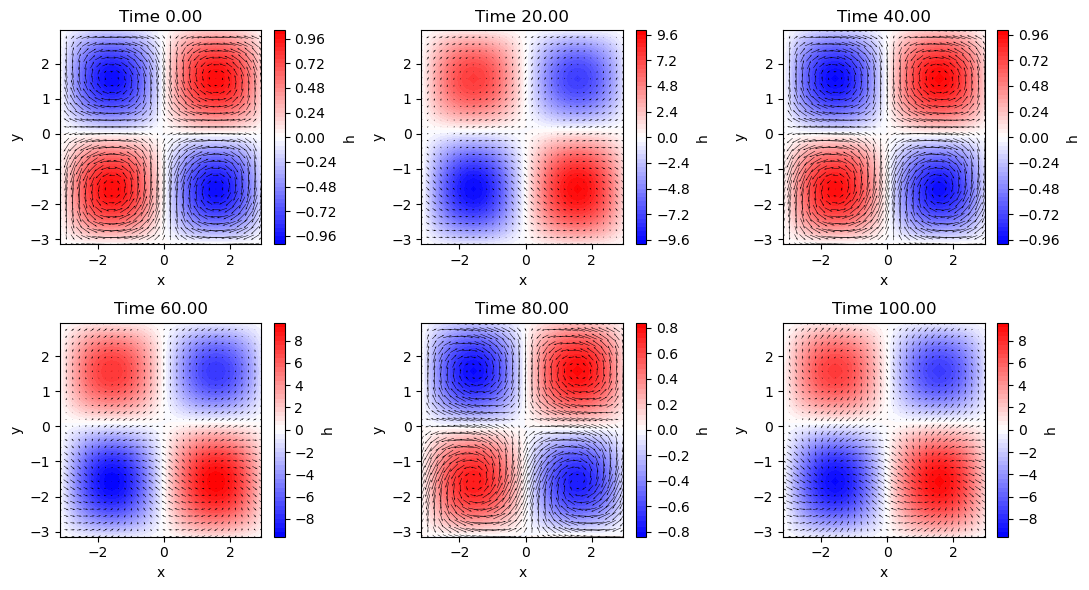

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Helper functions for derivatives in spectral space
def spectral_derivative_x(f_hat):
    return 1j * kx * f_hat

def spectral_derivative_y(f_hat):
    return 1j * ky * f_hat

# Define grid and parameters
N = 32  # Number of grid points in each direction
L = 2 * np.pi  # Domain length [-pi, pi)
dx = L / N
dy = L / N

x = np.linspace(-np.pi, np.pi, N, endpoint=False)
y = np.linspace(-np.pi, np.pi, N, endpoint=False)
X, Y = np.meshgrid(x, y)
kx = np.fft.fftfreq(N, d=dx / (2 * np.pi))  # Wavenumbers in x
ky = np.fft.fftfreq(N, d=dy / (2 * np.pi))  # Wavenumbers in y
kx, ky = np.meshgrid(kx, ky)
k_squared = kx**2 + ky**2
k_squared[0, 0] = 1  # Avoid division by zero for k_squared = 0

u = -2* np.pi * np.sin(x[:, None] + np.pi/2) * np.cos(y[None, :] + np.pi/2) + np.cos(y[None, :]) # Initial condition for u
v = 2* np.pi * np.cos(x[:, None] + np.pi/2) * np.sin(y[None, :] + np.pi/2) + np.cos(y[None, :])  # Initial condition for v
h = np.sin(x[:, None]) * np.sin(y[None, :])  # Initial condition for h

# Transform to spectral space
u_hat = np.fft.fft2(u)
v_hat = np.fft.fft2(v)
h_hat = np.fft.fft2(h)

# Time stepping parameters
dt = 1e-4  # Time step size
T = 100 # Total simulation time
steps = int(T / dt)

results = []
# Time integration using a simple leapfrog scheme
for step in range(steps+1):
    # Compute derivatives in spectral space
    u_x_hat = spectral_derivative_x(u_hat)
    v_y_hat = spectral_derivative_y(v_hat)
    h_x_hat = spectral_derivative_x(h_hat)
    h_y_hat = spectral_derivative_y(h_hat)
    
    # Update equations in spectral space
    u_hat_new = u_hat + dt * (v_hat - h_x_hat)
    v_hat_new = v_hat + dt * (-u_hat - h_y_hat)
    h_hat_new = h_hat + dt * (-u_x_hat - v_y_hat)
    
    # Update variables
    u_hat, v_hat, h_hat = u_hat_new, v_hat_new, h_hat_new

    # Save snapshots every 50 steps
    if step % 200000 == 0:
        u = np.fft.ifft2(u_hat).real
        v = np.fft.ifft2(v_hat).real
        h = np.fft.ifft2(h_hat).real
        results.append((u, v, h, step))

# Plot 6 snapshots (if there are enough saved results)
plt.figure(figsize=(11, 6))
num_snapshots = min(len(results), 6)

for idx in range(num_snapshots):
    u, v, h, step = results[idx]
    plt.subplot(2, 3, idx + 1)
    plt.contourf(x, y, h, levels=50, cmap="bwr")
    plt.colorbar(label="h")
    plt.quiver(x, y, u, v, scale=80, pivot='middle', color='black')
    plt.title(f"Time {step * dt:.2f}")
    plt.xlabel("x")
    plt.ylabel("y")

plt.tight_layout()
plt.show()

Fitted coefficients:
a: -0.03, b: -0.00, c: -0.00


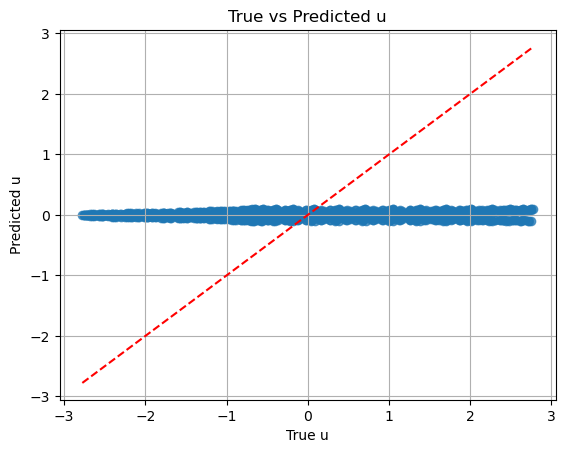

In [45]:
from sklearn.linear_model import LinearRegression
# Prepare data for regression
XY = np.column_stack((X.flatten(), Y.flatten()))  # Combine x and y into a feature matrix
u_ = u.flatten()

# Fit linear regression model
model = LinearRegression()
model.fit(XY, u.flatten())

# Extract the fitted coefficients
a_fitted, b_fitted = model.coef_
c_fitted = model.intercept_

# Display the results
print(f"Fitted coefficients:")
print(f"a: {a_fitted:.2f}, b: {b_fitted:.2f}, c: {c_fitted:.2f}")

# Predict values for validation
u_pred_ = model.predict(XY)

# Plot the true vs predicted values
plt.scatter(u_, u_pred_, alpha=0.7)
plt.plot([min(u_), max(u_)], [min(u_), max(u_)], color='red', linestyle='--')
plt.xlabel("True u")
plt.ylabel("Predicted u")
plt.title("True vs Predicted u")
plt.grid()
plt.show()

Text(0, 0.5, 'y')

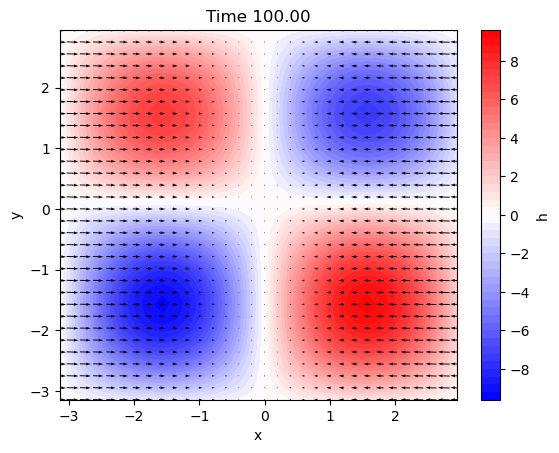

In [54]:
# Fit linear regression model
model = LinearRegression()
model.fit(XY, v.flatten())
# Extract the fitted coefficients
a_fitted, b_fitted = model.coef_
c_fitted = model.intercept_
# Predict values for validation
v_pred_ = model.predict(XY)
u_pred = u_pred_.reshape((N,N))
v_pred = v_pred_.reshape((N,N))
plt.contourf(x, y, h, levels=50, cmap="bwr")
plt.colorbar(label="h")
plt.quiver(x, y, u_pred, v_pred, scale=3, pivot='middle', color='black')
plt.title(f"Time {step * dt:.2f}")
plt.xlabel("x")
plt.ylabel("y")

#### even with linear flow model, if the initial state of the flow field u(x,y,0), v(x,y,0) is not linear to (x,y), the Lagrangian observation process will be a nonlinear process.